Start with some imports and the utility script from the comments

In [1]:
%%time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import tensorflow as tf
import time
t0 = time.time()

## this script transports l5kit and dependencies
os.system('pip uninstall typing -y')
os.system('pip install --target=/kaggle/working pymap3d==2.1.0')
os.system('pip install --target=/kaggle/working protobuf==3.12.2')
os.system('pip install --target=/kaggle/working transforms3d')
os.system('pip install --target=/kaggle/working zarr')
os.system('pip install --target=/kaggle/working ptable')

os.system('pip install --no-dependencies --target=/kaggle/working l5kit')
#!pip install --upgrade pip
#!pip install pymap3d==2.1.0
#!pip install -U l5kit

CPU times: user 2.73 s, sys: 1.85 s, total: 4.58 s
Wall time: 3.98 s


32512

Importing some stuff from the l5kit and setting the directories.

In [2]:
DIR_INPUT = "/home/moriarty/Downloads/lyft"
import os
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
SINGLE_MODE_SUBMISSION = f"{DIR_INPUT}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DIR_INPUT}/multi_mode_sample_submission.csv"
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.evaluation import write_pred_csv
from l5kit.rasterization import build_rasterizer

Config File (dictionary)  from the linked notebook.  This contains parameters for the training.

In [3]:
DEBUG = False  # True just trains for 10 steps instead of the full dataset
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 20,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },
    
    'train_params': {
        'max_num_steps': 10*1 if DEBUG else 800,
        'checkpoint_every_n_steps': 5000,
        'train_batch' : 32,
        'num_batch' : 10
        
        # 'eval_every_n_steps': -1
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    },
    
    
    
    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    },
    
    
}

Load In the train dataset.  I notice the pytorch folks can just import this with DataLoader, but I am not familiar with anything similar in keras.

In [4]:

train_cfg = cfg["train_data_loader"]

# Rasterizer
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader

train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
hist_shape = train_dataset[0]['history_positions'].shape
num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
num_in_channels = 3 + num_history_channels
num_targets = 2 * cfg["model_params"]["future_num_frames"]

print(train_dataset)


gc.collect()

/home/moriarty/.local/lib/python3.8/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


13

In [5]:
dataset_path1 = dm.require(cfg["valid_data_loader"]["key"])
valid_zarr = ChunkedDataset(dataset_path1).open()
valid_dataset = AgentDataset(cfg, valid_zarr, rasterizer)

In [6]:
valid_itr = iter(valid_dataset)
n_valid = 100

val_inputs = np.zeros(shape=(n_valid,224,224, num_in_channels) )
val_targets = np.zeros(shape=(n_valid,num_targets))
for itr in tqdm(range(n_valid)):
    data = next(valid_itr)

    val_inputs[itr] = data['image'].transpose(1,2,0)    
    val_targets[itr] = data['target_positions'].reshape(-1,num_targets)
    gc.collect()
del valid_dataset
    

100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


In [7]:
len(train_dataset)

22496709

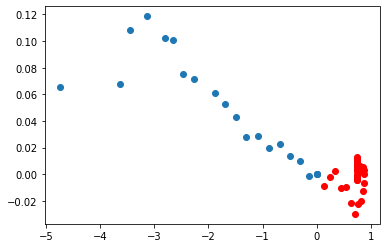

(50, 2)


In [8]:
idx = 100
plt.scatter(train_dataset[idx]['history_positions'][:,0],train_dataset[idx]['history_positions'][:,1])
plt.scatter(train_dataset[idx]['target_positions'][:,0],train_dataset[idx]['target_positions'][:,1],c='r')
plt.show()
print(train_dataset[0]['target_positions'].shape) 

define custom model here

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

from tensorflow.keras.applications import EfficientNetB0
base_in = Input(shape=(224,224,num_in_channels))
base_model=Conv2D(18,kernel_size=2,use_bias=False,padding="same")(base_in)
base_model=Conv2D(3,kernel_size=3,use_bias=False,padding="same")(base_model)
base_model = Dropout(.45)(base_model)

resnet_50 = ResNet50(include_top=False,
                       weights='imagenet',
                       input_tensor=Input(shape=(224,224,3)),
                       pooling='max'
                       )(base_model)
dense_model = Dropout(.45)(resnet_50)
#dense_model = base_model.output
dense_model = Dense(500, activation="linear")(dense_model)
dense_model = Dropout(.45)(dense_model)
dense_model = Dense(300, activation="linear")(dense_model)
dense_model = Dropout(.45)(dense_model)
dense_model = Dense(num_targets, activation="linear")(dense_model)
model = Model(inputs=base_in, outputs=dense_model)
opt = optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 45)]    0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 18)      3240      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 3)       486       
_________________________________________________________________
dropout_13 (Dropout)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)              

I am going to loop through the train_dataset and use a batch_size variable to train the model in batches.  

  0%|          | 0/800 [00:00<?, ?it/s]

2/2 [==============================] - ETA: 0s - loss: 749.1395
Epoch 00001: val_loss improved from inf to 15.16813, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 749.1395 - val_loss: 15.1681


  0%|          | 1/800 [00:29<6:33:12, 29.53s/it]

2/2 [==============================] - ETA: 0s - loss: 914.8195 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 914.8195 - val_loss: 40.4967


  0%|          | 2/800 [00:52<6:06:54, 27.59s/it]

2/2 [==============================] - ETA: 0s - loss: 440.6547
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 8s/step - loss: 440.6547 - val_loss: 619.5880


  0%|          | 3/800 [01:16<5:52:47, 26.56s/it]

2/2 [==============================] - ETA: 0s - loss: 255.6587
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 255.6587 - val_loss: 6540.2798


  0%|          | 4/800 [01:40<5:39:39, 25.60s/it]

2/2 [==============================] - ETA: 0s - loss: 162.3329
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 23s 12s/step - loss: 162.3329 - val_loss: 23727.2656


  1%|          | 5/800 [02:12<6:04:49, 27.53s/it]

2/2 [==============================] - ETA: 0s - loss: 123.8696
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 123.8696 - val_loss: 45477.7656


  1%|          | 6/800 [02:52<6:55:25, 31.39s/it]

2/2 [==============================] - ETA: 0s - loss: 80.5521
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 80.5521 - val_loss: 74442.9531


  1%|          | 7/800 [03:34<7:37:53, 34.64s/it]

2/2 [==============================] - ETA: 0s - loss: 156.0585
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 156.0585 - val_loss: 96850.2031


  1%|          | 8/800 [04:14<7:55:59, 36.06s/it]

2/2 [==============================] - ETA: 0s - loss: 138.3998
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 138.3998 - val_loss: 109283.2578


  1%|          | 9/800 [04:55<8:16:33, 37.67s/it]

2/2 [==============================] - ETA: 0s - loss: 35.5702
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 35.5702 - val_loss: 113944.1406


  1%|▏         | 10/800 [05:36<8:29:26, 38.69s/it]

2/2 [==============================] - ETA: 0s - loss: 74.3268
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 74.3268 - val_loss: 106977.1328


  1%|▏         | 11/800 [06:18<8:39:53, 39.54s/it]

2/2 [==============================] - ETA: 0s - loss: 91.0852
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 91.0852 - val_loss: 93961.0703


  2%|▏         | 12/800 [07:00<8:49:25, 40.31s/it]

2/2 [==============================] - ETA: 0s - loss: 91.3020 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 91.3020 - val_loss: 76622.7734


  2%|▏         | 13/800 [07:43<8:59:14, 41.11s/it]

2/2 [==============================] - ETA: 0s - loss: 57.0229
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 57.0229 - val_loss: 62034.6484


  2%|▏         | 14/800 [08:26<9:08:34, 41.88s/it]

2/2 [==============================] - ETA: 0s - loss: 42.5869
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 42.5869 - val_loss: 50630.2188


  2%|▏         | 15/800 [09:09<9:10:29, 42.08s/it]

2/2 [==============================] - ETA: 0s - loss: 39.4770
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 39.4770 - val_loss: 40091.3984


  2%|▏         | 16/800 [09:50<9:04:24, 41.66s/it]

2/2 [==============================] - ETA: 0s - loss: 37.4343
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 37.4343 - val_loss: 30311.8496


  2%|▏         | 17/800 [10:31<9:02:15, 41.55s/it]

2/2 [==============================] - ETA: 0s - loss: 22.0085
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 22.0085 - val_loss: 25359.4355


  2%|▏         | 18/800 [11:11<8:55:48, 41.11s/it]

2/2 [==============================] - ETA: 0s - loss: 16.8174
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 16.8174 - val_loss: 22951.6641


  2%|▏         | 19/800 [11:52<8:53:47, 41.01s/it]

2/2 [==============================] - ETA: 0s - loss: 9.9719 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 9.9719 - val_loss: 20938.3203


  2%|▎         | 20/800 [12:34<8:56:47, 41.29s/it]

2/2 [==============================] - ETA: 0s - loss: 7.9925
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 7.9925 - val_loss: 18680.2578


  3%|▎         | 21/800 [13:15<8:56:03, 41.29s/it]

2/2 [==============================] - ETA: 0s - loss: 9.0776
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 9.0776 - val_loss: 16309.7100


  3%|▎         | 22/800 [13:57<8:59:01, 41.57s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1436
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 5.1436 - val_loss: 14024.3008


  3%|▎         | 23/800 [14:39<8:57:22, 41.50s/it]

2/2 [==============================] - ETA: 0s - loss: 5.8468
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 5.8468 - val_loss: 11675.7139


  3%|▎         | 24/800 [15:19<8:54:16, 41.31s/it]

2/2 [==============================] - ETA: 0s - loss: 7.5721 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 7.5721 - val_loss: 9731.9404


  3%|▎         | 25/800 [16:02<8:58:49, 41.72s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9227
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 2.9227 - val_loss: 8143.4712


  3%|▎         | 26/800 [16:43<8:55:02, 41.48s/it]

2/2 [==============================] - ETA: 0s - loss: 3.4030
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 14s/step - loss: 3.4030 - val_loss: 6777.9644


  3%|▎         | 27/800 [17:26<8:58:25, 41.79s/it]

2/2 [==============================] - ETA: 0s - loss: 27.0459
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 27.0459 - val_loss: 5531.1479


  4%|▎         | 28/800 [18:07<8:57:05, 41.74s/it]

2/2 [==============================] - ETA: 0s - loss: 99.8421 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 16s 8s/step - loss: 99.8421 - val_loss: 4460.3496


  4%|▎         | 29/800 [18:37<8:09:42, 38.11s/it]

2/2 [==============================] - ETA: 0s - loss: 48.7260
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 48.7260 - val_loss: 3613.9194


  4%|▍         | 30/800 [19:00<7:11:39, 33.64s/it]

2/2 [==============================] - ETA: 0s - loss: 86.6814
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 8s/step - loss: 86.6814 - val_loss: 2920.1150


  4%|▍         | 31/800 [19:24<6:34:08, 30.75s/it]

2/2 [==============================] - ETA: 0s - loss: 86.1124
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 86.1124 - val_loss: 2357.0762


  4%|▍         | 32/800 [19:47<6:03:56, 28.43s/it]

2/2 [==============================] - ETA: 0s - loss: 2.0436
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 2.0436 - val_loss: 1929.5175


  4%|▍         | 33/800 [20:10<5:43:18, 26.86s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2651
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 2.2651 - val_loss: 1607.9937


  4%|▍         | 34/800 [20:33<5:28:14, 25.71s/it]

2/2 [==============================] - ETA: 0s - loss: 52.8452
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 52.8452 - val_loss: 1346.4556


  4%|▍         | 35/800 [21:09<6:05:06, 28.64s/it]

2/2 [==============================] - ETA: 0s - loss: 104.3278
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 104.3278 - val_loss: 1139.4153


  4%|▍         | 36/800 [21:49<6:48:52, 32.11s/it]

2/2 [==============================] - ETA: 0s - loss: 18.2523
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 18.2523 - val_loss: 960.2971


  5%|▍         | 37/800 [22:29<7:19:50, 34.59s/it]

2/2 [==============================] - ETA: 0s - loss: 9.9084
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 9.9084 - val_loss: 857.0302


  5%|▍         | 38/800 [23:11<7:47:10, 36.79s/it]

2/2 [==============================] - ETA: 0s - loss: 13.3560
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 13.3560 - val_loss: 764.6732


  5%|▍         | 39/800 [23:52<8:00:43, 37.90s/it]

2/2 [==============================] - ETA: 0s - loss: 31.5930
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 31.5930 - val_loss: 677.9833


  5%|▌         | 40/800 [24:34<8:16:43, 39.21s/it]

2/2 [==============================] - ETA: 0s - loss: 141.5731
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 141.5731 - val_loss: 736.0598


  5%|▌         | 41/800 [25:15<8:22:38, 39.73s/it]

2/2 [==============================] - ETA: 0s - loss: 188.5937
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 188.5937 - val_loss: 808.8485


  5%|▌         | 42/800 [25:56<8:25:21, 40.00s/it]

2/2 [==============================] - ETA: 0s - loss: 150.7411
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 150.7411 - val_loss: 995.4855


  5%|▌         | 43/800 [26:37<8:29:50, 40.41s/it]

2/2 [==============================] - ETA: 0s - loss: 47.3942
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 47.3942 - val_loss: 1317.0328


  6%|▌         | 44/800 [27:17<8:28:26, 40.35s/it]

2/2 [==============================] - ETA: 0s - loss: 6.6652
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 6.6652 - val_loss: 1700.9847


  6%|▌         | 45/800 [27:58<8:29:21, 40.48s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6008
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 2.6008 - val_loss: 2062.2959


  6%|▌         | 46/800 [28:40<8:36:07, 41.07s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8336
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 12s/step - loss: 2.8336 - val_loss: 2263.2505


  6%|▌         | 47/800 [29:21<8:32:57, 40.87s/it]

2/2 [==============================] - ETA: 0s - loss: 2.1073
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 2.1073 - val_loss: 2342.8765


  6%|▌         | 48/800 [30:03<8:37:40, 41.30s/it]

2/2 [==============================] - ETA: 0s - loss: 3.7014
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 3.7014 - val_loss: 2308.3640


  6%|▌         | 49/800 [30:44<8:34:03, 41.07s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8552
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 2.8552 - val_loss: 2256.8486


  6%|▋         | 50/800 [31:24<8:31:31, 40.92s/it]

2/2 [==============================] - ETA: 0s - loss: 2.0424
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 2.0424 - val_loss: 2185.8467


  6%|▋         | 51/800 [32:07<8:36:26, 41.37s/it]

2/2 [==============================] - ETA: 0s - loss: 29.1306
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 29.1306 - val_loss: 2266.0493


  6%|▋         | 52/800 [32:47<8:30:16, 40.93s/it]

2/2 [==============================] - ETA: 0s - loss: 31.1640
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 27s 13s/step - loss: 31.1640 - val_loss: 2318.2256


  7%|▋         | 53/800 [33:28<8:32:58, 41.20s/it]

2/2 [==============================] - ETA: 0s - loss: 19.1334
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 19.1334 - val_loss: 2860.6450


  7%|▋         | 54/800 [34:10<8:33:56, 41.34s/it]

2/2 [==============================] - ETA: 0s - loss: 72.1562 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 72.1562 - val_loss: 3670.3313


  7%|▋         | 55/800 [34:51<8:32:58, 41.31s/it]

2/2 [==============================] - ETA: 0s - loss: 17.6628
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 26s 13s/step - loss: 17.6628 - val_loss: 2399.1399


  7%|▋         | 56/800 [35:33<8:35:05, 41.54s/it]

2/2 [==============================] - ETA: 0s - loss: 52.3029
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 22s 11s/step - loss: 52.3029 - val_loss: 1275.9886


  7%|▋         | 57/800 [36:11<8:18:27, 40.25s/it]

2/2 [==============================] - ETA: 0s - loss: 103.4044
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 103.4044 - val_loss: 778.9975


  7%|▋         | 58/800 [36:34<7:16:37, 35.31s/it]

2/2 [==============================] - ETA: 0s - loss: 198.8984
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 16s 8s/step - loss: 198.8984 - val_loss: 552.0062


  7%|▋         | 59/800 [36:59<6:36:26, 32.10s/it]

2/2 [==============================] - ETA: 0s - loss: 170.3155
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 15s 7s/step - loss: 170.3155 - val_loss: 393.5721


  8%|▊         | 60/800 [37:22<6:03:57, 29.51s/it]

2/2 [==============================] - ETA: 0s - loss: 6.9756
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 16s 8s/step - loss: 6.9756 - val_loss: 285.1297


  8%|▊         | 61/800 [37:48<5:48:00, 28.26s/it]

2/2 [==============================] - ETA: 0s - loss: 27.5014
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 23s 12s/step - loss: 27.5014 - val_loss: 236.0161


  8%|▊         | 62/800 [38:27<6:27:12, 31.48s/it]

2/2 [==============================] - ETA: 0s - loss: 7.5482
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 12s/step - loss: 7.5482 - val_loss: 212.9535


  8%|▊         | 63/800 [39:08<7:00:44, 34.25s/it]

2/2 [==============================] - ETA: 0s - loss: 4.3977
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 4.3977 - val_loss: 200.1449


  8%|▊         | 64/800 [39:48<7:24:00, 36.20s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1477
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 12s/step - loss: 3.1477 - val_loss: 190.2548


  8%|▊         | 65/800 [40:28<7:35:46, 37.21s/it]

2/2 [==============================] - ETA: 0s - loss: 137.0238
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 137.0238 - val_loss: 262.7161


  8%|▊         | 66/800 [41:07<7:41:23, 37.72s/it]

2/2 [==============================] - ETA: 0s - loss: 7.0272
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 7.0272 - val_loss: 316.1977


  8%|▊         | 67/800 [41:45<7:42:57, 37.90s/it]

2/2 [==============================] - ETA: 0s - loss: 59.7407
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 59.7407 - val_loss: 361.2923


  8%|▊         | 68/800 [42:25<7:49:08, 38.45s/it]

2/2 [==============================] - ETA: 0s - loss: 17.9655
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 22s 11s/step - loss: 17.9655 - val_loss: 383.7993


  9%|▊         | 69/800 [43:02<7:43:02, 38.01s/it]

2/2 [==============================] - ETA: 0s - loss: 48.5690
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 48.5690 - val_loss: 458.0019


  9%|▉         | 70/800 [43:41<7:45:21, 38.25s/it]

2/2 [==============================] - ETA: 0s - loss: 181.8171
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 13s/step - loss: 181.8171 - val_loss: 725.1005


  9%|▉         | 71/800 [44:20<7:49:14, 38.62s/it]

2/2 [==============================] - ETA: 0s - loss: 63.1882
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 63.1882 - val_loss: 540.6953


  9%|▉         | 72/800 [44:58<7:46:13, 38.42s/it]

2/2 [==============================] - ETA: 0s - loss: 17.8167
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 24s 12s/step - loss: 17.8167 - val_loss: 219.8072


  9%|▉         | 73/800 [45:36<7:43:55, 38.29s/it]

2/2 [==============================] - ETA: 0s - loss: 8.1290 
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 12s/step - loss: 8.1290 - val_loss: 69.1966


  9%|▉         | 74/800 [46:15<7:47:18, 38.62s/it]

2/2 [==============================] - ETA: 0s - loss: 8.4474
Epoch 00001: val_loss did not improve from 15.16813
2/2 [==============================] - 25s 12s/step - loss: 8.4474 - val_loss: 22.7563


  9%|▉         | 75/800 [46:54<7:45:45, 38.55s/it]

2/2 [==============================] - ETA: 0s - loss: 9.4105
Epoch 00001: val_loss improved from 15.16813 to 7.49623, saving model to ./model.h5
2/2 [==============================] - 24s 12s/step - loss: 9.4105 - val_loss: 7.4962


 10%|▉         | 76/800 [47:33<7:46:13, 38.64s/it]

2/2 [==============================] - ETA: 0s - loss: 9.0750
Epoch 00001: val_loss improved from 7.49623 to 2.97600, saving model to ./model.h5
2/2 [==============================] - 25s 12s/step - loss: 9.0750 - val_loss: 2.9760


 10%|▉         | 77/800 [48:13<7:52:10, 39.19s/it]

2/2 [==============================] - ETA: 0s - loss: 8.9458
Epoch 00001: val_loss improved from 2.97600 to 2.12257, saving model to ./model.h5
2/2 [==============================] - 25s 13s/step - loss: 8.9458 - val_loss: 2.1226


 10%|▉         | 78/800 [48:52<7:52:02, 39.23s/it]

2/2 [==============================] - ETA: 0s - loss: 11.2123
Epoch 00001: val_loss improved from 2.12257 to 1.99641, saving model to ./model.h5
2/2 [==============================] - 27s 13s/step - loss: 11.2123 - val_loss: 1.9964


 10%|▉         | 79/800 [49:34<7:59:44, 39.92s/it]

2/2 [==============================] - ETA: 0s - loss: 14.5214
Epoch 00001: val_loss improved from 1.99641 to 1.93999, saving model to ./model.h5
2/2 [==============================] - 26s 13s/step - loss: 14.5214 - val_loss: 1.9400


 10%|█         | 80/800 [50:14<7:59:30, 39.96s/it]

2/2 [==============================] - ETA: 0s - loss: 24.7073
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 24.7073 - val_loss: 1.9798


 10%|█         | 81/800 [50:54<7:57:47, 39.87s/it]

2/2 [==============================] - ETA: 0s - loss: 55.5371
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 55.5371 - val_loss: 1.9990


 10%|█         | 82/800 [51:31<7:49:02, 39.20s/it]

2/2 [==============================] - ETA: 0s - loss: 116.7863
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 13s/step - loss: 116.7863 - val_loss: 1.9924


 10%|█         | 83/800 [52:12<7:52:08, 39.51s/it]

2/2 [==============================] - ETA: 0s - loss: 32.4374
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 13s/step - loss: 32.4374 - val_loss: 1.9894


 10%|█         | 84/800 [52:51<7:51:39, 39.53s/it]

2/2 [==============================] - ETA: 0s - loss: 76.8441
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 24s 12s/step - loss: 76.8441 - val_loss: 1.9816


 11%|█         | 85/800 [53:31<7:53:54, 39.77s/it]

2/2 [==============================] - ETA: 0s - loss: 43.7798
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 43.7798 - val_loss: 1.9699


 11%|█         | 86/800 [54:11<7:53:10, 39.76s/it]

2/2 [==============================] - ETA: 0s - loss: 11.4855
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 26s 13s/step - loss: 11.4855 - val_loss: 1.9688


 11%|█         | 87/800 [54:52<7:55:08, 39.98s/it]

2/2 [==============================] - ETA: 0s - loss: 6.5527
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 6.5527 - val_loss: 1.9644


 11%|█         | 88/800 [55:31<7:52:57, 39.86s/it]

2/2 [==============================] - ETA: 0s - loss: 4.0007
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 4.0007 - val_loss: 1.9645


 11%|█         | 89/800 [56:12<7:54:00, 40.00s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2159
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 26s 13s/step - loss: 3.2159 - val_loss: 1.9674


 11%|█▏        | 90/800 [56:52<7:56:22, 40.26s/it]

2/2 [==============================] - ETA: 0s - loss: 13.5288
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 13s/step - loss: 13.5288 - val_loss: 1.9666


 11%|█▏        | 91/800 [57:33<7:55:47, 40.26s/it]

2/2 [==============================] - ETA: 0s - loss: 74.3373 
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 25s 12s/step - loss: 74.3373 - val_loss: 1.9639


 12%|█▏        | 92/800 [58:13<7:53:36, 40.14s/it]

2/2 [==============================] - ETA: 0s - loss: 137.0249
Epoch 00001: val_loss did not improve from 1.93999
2/2 [==============================] - 23s 11s/step - loss: 137.0249 - val_loss: 1.9415


 12%|█▏        | 93/800 [58:51<7:46:46, 39.61s/it]

2/2 [==============================] - ETA: 0s - loss: 155.4608
Epoch 00001: val_loss improved from 1.93999 to 1.90809, saving model to ./model.h5
2/2 [==============================] - 22s 11s/step - loss: 155.4608 - val_loss: 1.9081


 12%|█▏        | 94/800 [59:26<7:31:17, 38.35s/it]

2/2 [==============================] - ETA: 0s - loss: 99.0975 
Epoch 00001: val_loss improved from 1.90809 to 1.88479, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 99.0975 - val_loss: 1.8848


 12%|█▏        | 95/800 [59:52<6:47:14, 34.66s/it]

2/2 [==============================] - ETA: 0s - loss: 43.2411
Epoch 00001: val_loss improved from 1.88479 to 1.86421, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 43.2411 - val_loss: 1.8642


 12%|█▏        | 96/800 [1:00:17<6:10:48, 31.60s/it]

2/2 [==============================] - ETA: 0s - loss: 28.0889
Epoch 00001: val_loss did not improve from 1.86421
2/2 [==============================] - 15s 7s/step - loss: 28.0889 - val_loss: 1.8644


 12%|█▏        | 97/800 [1:00:40<5:41:14, 29.12s/it]

2/2 [==============================] - ETA: 0s - loss: 9.9176 
Epoch 00001: val_loss improved from 1.86421 to 1.86408, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 9.9176 - val_loss: 1.8641


 12%|█▏        | 98/800 [1:01:04<5:21:04, 27.44s/it]

2/2 [==============================] - ETA: 0s - loss: 4.4951
Epoch 00001: val_loss did not improve from 1.86408
2/2 [==============================] - 15s 7s/step - loss: 4.4951 - val_loss: 1.8879


 12%|█▏        | 99/800 [1:01:27<5:06:05, 26.20s/it]

2/2 [==============================] - ETA: 0s - loss: 4.3530
Epoch 00001: val_loss did not improve from 1.86408
2/2 [==============================] - 15s 7s/step - loss: 4.3530 - val_loss: 1.9085


 12%|█▎        | 100/800 [1:01:50<4:55:59, 25.37s/it]

2/2 [==============================] - ETA: 0s - loss: 4.4265
Epoch 00001: val_loss improved from 1.86408 to 1.86373, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 4.4265 - val_loss: 1.8637


 13%|█▎        | 101/800 [1:02:17<4:59:48, 25.73s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0704
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 10s/step - loss: 3.0704 - val_loss: 1.9960


 13%|█▎        | 102/800 [1:02:50<5:24:34, 27.90s/it]

2/2 [==============================] - ETA: 0s - loss: 12.6810
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 19s 9s/step - loss: 12.6810 - val_loss: 1.9323


 13%|█▎        | 103/800 [1:03:19<5:28:10, 28.25s/it]

2/2 [==============================] - ETA: 0s - loss: 48.4205
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 26s 13s/step - loss: 48.4205 - val_loss: 2.9449


 13%|█▎        | 104/800 [1:04:01<6:14:37, 32.30s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3076
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 23s 12s/step - loss: 2.3076 - val_loss: 6.6879


 13%|█▎        | 105/800 [1:04:36<6:25:45, 33.30s/it]

2/2 [==============================] - ETA: 0s - loss: 2.0637
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 25s 12s/step - loss: 2.0637 - val_loss: 11.1466


 13%|█▎        | 106/800 [1:05:17<6:49:43, 35.42s/it]

2/2 [==============================] - ETA: 0s - loss: 14.4561
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 16s 8s/step - loss: 14.4561 - val_loss: 15.4514


 13%|█▎        | 107/800 [1:05:45<6:24:06, 33.26s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2312
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 26s 13s/step - loss: 2.2312 - val_loss: 18.2502


 14%|█▎        | 108/800 [1:06:25<6:45:56, 35.20s/it]

2/2 [==============================] - ETA: 0s - loss: 1.7133
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 20s 10s/step - loss: 1.7133 - val_loss: 18.3810


 14%|█▎        | 109/800 [1:07:00<6:45:22, 35.20s/it]

2/2 [==============================] - ETA: 0s - loss: 41.8458
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 20s 10s/step - loss: 41.8458 - val_loss: 16.7836


 14%|█▍        | 110/800 [1:07:35<6:45:29, 35.26s/it]

2/2 [==============================] - ETA: 0s - loss: 26.5458
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 10s/step - loss: 26.5458 - val_loss: 16.2280


 14%|█▍        | 111/800 [1:08:11<6:45:40, 35.33s/it]

2/2 [==============================] - ETA: 0s - loss: 12.2100
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 23s 12s/step - loss: 12.2100 - val_loss: 14.9851


 14%|█▍        | 112/800 [1:08:50<6:58:12, 36.47s/it]

2/2 [==============================] - ETA: 0s - loss: 3.3334
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 15s 8s/step - loss: 3.3334 - val_loss: 13.4737


 14%|█▍        | 113/800 [1:09:18<6:29:47, 34.04s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7752
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 14s 7s/step - loss: 0.7752 - val_loss: 11.4173


 14%|█▍        | 114/800 [1:09:41<5:48:48, 30.51s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7128
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 16s 8s/step - loss: 0.7128 - val_loss: 9.3924


 14%|█▍        | 115/800 [1:10:05<5:27:25, 28.68s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5967
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 17s 8s/step - loss: 1.5967 - val_loss: 8.0433


 14%|█▍        | 116/800 [1:10:32<5:21:37, 28.21s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5043
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 16s 8s/step - loss: 1.5043 - val_loss: 6.5170


 15%|█▍        | 117/800 [1:10:59<5:16:25, 27.80s/it]

2/2 [==============================] - ETA: 0s - loss: 1.2953
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 14s 7s/step - loss: 1.2953 - val_loss: 5.2836


 15%|█▍        | 118/800 [1:11:22<5:00:34, 26.44s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3356
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 14s 7s/step - loss: 1.3356 - val_loss: 4.3265


 15%|█▍        | 119/800 [1:11:45<4:46:34, 25.25s/it]

2/2 [==============================] - ETA: 0s - loss: 1.7760
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 15s 7s/step - loss: 1.7760 - val_loss: 3.3908


 15%|█▌        | 120/800 [1:12:08<4:40:00, 24.71s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4037
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 10s/step - loss: 2.4037 - val_loss: 2.7122


 15%|█▌        | 121/800 [1:12:38<4:56:27, 26.20s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6900
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 17s 9s/step - loss: 2.6900 - val_loss: 2.4359


 15%|█▌        | 122/800 [1:13:07<5:06:38, 27.14s/it]

2/2 [==============================] - ETA: 0s - loss: 3.8676
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 22s 11s/step - loss: 3.8676 - val_loss: 2.2989


 15%|█▌        | 123/800 [1:13:46<5:47:06, 30.76s/it]

2/2 [==============================] - ETA: 0s - loss: 4.0928
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 11s/step - loss: 4.0928 - val_loss: 2.3690


 16%|█▌        | 124/800 [1:14:20<5:54:47, 31.49s/it]

2/2 [==============================] - ETA: 0s - loss: 4.2945
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 10s/step - loss: 4.2945 - val_loss: 2.4752


 16%|█▌        | 125/800 [1:14:51<5:55:38, 31.61s/it]

2/2 [==============================] - ETA: 0s - loss: 6.0737
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 15s 7s/step - loss: 6.0737 - val_loss: 2.4574


 16%|█▌        | 126/800 [1:15:17<5:32:55, 29.64s/it]

2/2 [==============================] - ETA: 0s - loss: 8.9011 
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 15s 8s/step - loss: 8.9011 - val_loss: 2.2398


 16%|█▌        | 127/800 [1:15:42<5:18:34, 28.40s/it]

2/2 [==============================] - ETA: 0s - loss: 7.0645
Epoch 00001: val_loss did not improve from 1.86373
2/2 [==============================] - 21s 11s/step - loss: 7.0645 - val_loss: 1.9361


 16%|█▌        | 128/800 [1:16:14<5:30:53, 29.54s/it]

2/2 [==============================] - ETA: 0s - loss: 0.9648
Epoch 00001: val_loss improved from 1.86373 to 1.69855, saving model to ./model.h5
2/2 [==============================] - 20s 10s/step - loss: 0.9648 - val_loss: 1.6985


 16%|█▌        | 129/800 [1:16:48<5:46:14, 30.96s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1072
Epoch 00001: val_loss improved from 1.69855 to 1.59655, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 1.1072 - val_loss: 1.5966


 16%|█▋        | 130/800 [1:17:24<5:59:27, 32.19s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0764
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 15s 7s/step - loss: 1.0764 - val_loss: 1.6009


 16%|█▋        | 131/800 [1:17:48<5:32:54, 29.86s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1586
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 17s 9s/step - loss: 1.1586 - val_loss: 1.7795


 16%|█▋        | 132/800 [1:18:16<5:25:31, 29.24s/it]

2/2 [==============================] - ETA: 0s - loss: 9.1957 
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 16s 8s/step - loss: 9.1957 - val_loss: 1.9418


 17%|█▋        | 133/800 [1:18:46<5:29:07, 29.61s/it]

2/2 [==============================] - ETA: 0s - loss: 132.3415
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 15s 7s/step - loss: 132.3415 - val_loss: 1.9120


 17%|█▋        | 134/800 [1:19:11<5:11:57, 28.10s/it]

2/2 [==============================] - ETA: 0s - loss: 42.9310
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 16s 8s/step - loss: 42.9310 - val_loss: 1.9056


 17%|█▋        | 135/800 [1:19:36<5:03:03, 27.34s/it]

2/2 [==============================] - ETA: 0s - loss: 28.8004
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 17s 8s/step - loss: 28.8004 - val_loss: 1.8634


 17%|█▋        | 136/800 [1:20:03<4:59:36, 27.07s/it]

2/2 [==============================] - ETA: 0s - loss: 9.4913
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 19s 9s/step - loss: 9.4913 - val_loss: 1.8266


 17%|█▋        | 137/800 [1:20:34<5:12:04, 28.24s/it]

2/2 [==============================] - ETA: 0s - loss: 0.8680
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 17s 9s/step - loss: 0.8680 - val_loss: 1.8229


 17%|█▋        | 138/800 [1:21:04<5:17:28, 28.77s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7623
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 15s 8s/step - loss: 0.7623 - val_loss: 1.8477


 17%|█▋        | 139/800 [1:21:29<5:04:34, 27.65s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6484
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 23s 11s/step - loss: 0.6484 - val_loss: 1.8280


 18%|█▊        | 140/800 [1:22:02<5:20:46, 29.16s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5659
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 21s 11s/step - loss: 0.5659 - val_loss: 1.8045


 18%|█▊        | 141/800 [1:22:39<5:49:01, 31.78s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4418
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 15s 8s/step - loss: 0.4418 - val_loss: 1.7880


 18%|█▊        | 142/800 [1:23:04<5:25:21, 29.67s/it]

2/2 [==============================] - ETA: 0s - loss: 9.1128 
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 12s 6s/step - loss: 9.1128 - val_loss: 1.7757


 18%|█▊        | 143/800 [1:23:26<4:58:17, 27.24s/it]

2/2 [==============================] - ETA: 0s - loss: 27.4498
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 17s 8s/step - loss: 27.4498 - val_loss: 1.7622


 18%|█▊        | 144/800 [1:23:51<4:50:56, 26.61s/it]

2/2 [==============================] - ETA: 0s - loss: 23.4945
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 16s 8s/step - loss: 23.4945 - val_loss: 1.7536


 18%|█▊        | 145/800 [1:24:17<4:47:27, 26.33s/it]

2/2 [==============================] - ETA: 0s - loss: 28.2870
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 15s 8s/step - loss: 28.2870 - val_loss: 1.7517


 18%|█▊        | 146/800 [1:24:41<4:42:24, 25.91s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6183
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 14s 7s/step - loss: 0.6183 - val_loss: 1.7587


 18%|█▊        | 147/800 [1:25:06<4:38:41, 25.61s/it]

2/2 [==============================] - ETA: 0s - loss: 19.3156
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 14s 7s/step - loss: 19.3156 - val_loss: 1.7603


 18%|█▊        | 148/800 [1:25:28<4:26:22, 24.51s/it]

2/2 [==============================] - ETA: 0s - loss: 23.6822
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 13s 7s/step - loss: 23.6822 - val_loss: 1.7449


 19%|█▊        | 149/800 [1:25:52<4:23:50, 24.32s/it]

2/2 [==============================] - ETA: 0s - loss: 17.5310
Epoch 00001: val_loss did not improve from 1.59655
2/2 [==============================] - 20s 10s/step - loss: 17.5310 - val_loss: 1.6891


 19%|█▉        | 150/800 [1:26:20<4:36:09, 25.49s/it]

2/2 [==============================] - ETA: 0s - loss: 20.0304
Epoch 00001: val_loss improved from 1.59655 to 1.58669, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 20.0304 - val_loss: 1.5867


 19%|█▉        | 151/800 [1:26:43<4:26:04, 24.60s/it]

2/2 [==============================] - ETA: 0s - loss: 15.8650
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 15.8650 - val_loss: 1.6367


 19%|█▉        | 152/800 [1:27:04<4:13:10, 23.44s/it]

2/2 [==============================] - ETA: 0s - loss: 12.3091
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 12.3091 - val_loss: 1.6991


 19%|█▉        | 153/800 [1:27:24<4:03:31, 22.58s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4067
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 2.4067 - val_loss: 1.7486


 19%|█▉        | 154/800 [1:27:45<3:57:03, 22.02s/it]

2/2 [==============================] - ETA: 0s - loss: 1.2242
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 8s/step - loss: 1.2242 - val_loss: 1.7587


 19%|█▉        | 155/800 [1:28:08<4:01:32, 22.47s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1820
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 7s/step - loss: 1.1820 - val_loss: 1.7537


 20%|█▉        | 156/800 [1:28:34<4:10:21, 23.32s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7844
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 8s/step - loss: 0.7844 - val_loss: 1.7485


 20%|█▉        | 157/800 [1:28:59<4:15:16, 23.82s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7139
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 0.7139 - val_loss: 1.7477


 20%|█▉        | 158/800 [1:29:20<4:06:59, 23.08s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5287
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 0.5287 - val_loss: 1.7464


 20%|█▉        | 159/800 [1:29:41<3:58:54, 22.36s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9805
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 7s/step - loss: 2.9805 - val_loss: 1.7430


 20%|██        | 160/800 [1:30:02<3:55:34, 22.08s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3411
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 0.3411 - val_loss: 1.7439


 20%|██        | 161/800 [1:30:23<3:51:21, 21.72s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3522
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 0.3522 - val_loss: 1.7476


 20%|██        | 162/800 [1:30:44<3:47:50, 21.43s/it]

2/2 [==============================] - ETA: 0s - loss: 12.4743
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 12.4743 - val_loss: 1.7488


 20%|██        | 163/800 [1:31:05<3:45:01, 21.19s/it]

2/2 [==============================] - ETA: 0s - loss: 22.5153
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 6s/step - loss: 22.5153 - val_loss: 1.7453


 20%|██        | 164/800 [1:31:25<3:42:54, 21.03s/it]

2/2 [==============================] - ETA: 0s - loss: 31.2640
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 13s 7s/step - loss: 31.2640 - val_loss: 1.7341


 21%|██        | 165/800 [1:31:47<3:43:48, 21.15s/it]

2/2 [==============================] - ETA: 0s - loss: 27.3717
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 7s/step - loss: 27.3717 - val_loss: 1.7081


 21%|██        | 166/800 [1:32:10<3:51:04, 21.87s/it]

2/2 [==============================] - ETA: 0s - loss: 12.2415
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 8s/step - loss: 12.2415 - val_loss: 1.6667


 21%|██        | 167/800 [1:32:35<3:59:54, 22.74s/it]

2/2 [==============================] - ETA: 0s - loss: 9.5034
Epoch 00001: val_loss did not improve from 1.58669
2/2 [==============================] - 15s 7s/step - loss: 9.5034 - val_loss: 1.6134


 21%|██        | 168/800 [1:33:00<4:05:23, 23.30s/it]

2/2 [==============================] - ETA: 0s - loss: 21.2120
Epoch 00001: val_loss improved from 1.58669 to 1.56392, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 21.2120 - val_loss: 1.5639


 21%|██        | 169/800 [1:33:21<4:00:21, 22.86s/it]

2/2 [==============================] - ETA: 0s - loss: 20.9813
Epoch 00001: val_loss improved from 1.56392 to 1.52158, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 20.9813 - val_loss: 1.5216


 21%|██▏       | 170/800 [1:33:42<3:53:32, 22.24s/it]

2/2 [==============================] - ETA: 0s - loss: 7.4810
Epoch 00001: val_loss improved from 1.52158 to 1.49332, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 7.4810 - val_loss: 1.4933


 21%|██▏       | 171/800 [1:34:03<3:48:44, 21.82s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1144
Epoch 00001: val_loss improved from 1.49332 to 1.46786, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 3.1144 - val_loss: 1.4679


 22%|██▏       | 172/800 [1:34:27<3:55:20, 22.48s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6995
Epoch 00001: val_loss improved from 1.46786 to 1.45381, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 1.6995 - val_loss: 1.4538


 22%|██▏       | 173/800 [1:34:47<3:47:28, 21.77s/it]

2/2 [==============================] - ETA: 0s - loss: 1.4620
Epoch 00001: val_loss improved from 1.45381 to 1.44842, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 1.4620 - val_loss: 1.4484


 22%|██▏       | 174/800 [1:35:08<3:43:58, 21.47s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0689
Epoch 00001: val_loss improved from 1.44842 to 1.44624, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 1.0689 - val_loss: 1.4462


 22%|██▏       | 175/800 [1:35:28<3:38:42, 21.00s/it]

2/2 [==============================] - ETA: 0s - loss: 0.8294
Epoch 00001: val_loss improved from 1.44624 to 1.44035, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.8294 - val_loss: 1.4404


 22%|██▏       | 176/800 [1:35:48<3:34:42, 20.64s/it]

2/2 [==============================] - ETA: 0s - loss: 31.1658
Epoch 00001: val_loss improved from 1.44035 to 1.42688, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 31.1658 - val_loss: 1.4269


 22%|██▏       | 177/800 [1:36:09<3:36:48, 20.88s/it]

2/2 [==============================] - ETA: 0s - loss: 19.8541
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 19.8541 - val_loss: 1.4386


 22%|██▏       | 178/800 [1:36:32<3:42:34, 21.47s/it]

2/2 [==============================] - ETA: 0s - loss: 14.4284
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 15s 7s/step - loss: 14.4284 - val_loss: 1.4771


 22%|██▏       | 179/800 [1:36:56<3:50:15, 22.25s/it]

2/2 [==============================] - ETA: 0s - loss: 11.3038
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 11.3038 - val_loss: 1.6271


 22%|██▎       | 180/800 [1:37:17<3:45:16, 21.80s/it]

2/2 [==============================] - ETA: 0s - loss: 9.3695 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 9.3695 - val_loss: 1.8281


 23%|██▎       | 181/800 [1:37:38<3:43:36, 21.67s/it]

2/2 [==============================] - ETA: 0s - loss: 9.7722 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 9.7722 - val_loss: 1.9680


 23%|██▎       | 182/800 [1:37:58<3:36:48, 21.05s/it]

2/2 [==============================] - ETA: 0s - loss: 6.8931
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 6.8931 - val_loss: 2.0263


 23%|██▎       | 183/800 [1:38:18<3:32:43, 20.69s/it]

2/2 [==============================] - ETA: 0s - loss: 3.9267
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 3.9267 - val_loss: 2.1489


 23%|██▎       | 184/800 [1:38:38<3:31:10, 20.57s/it]

2/2 [==============================] - ETA: 0s - loss: 2.0509
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 2.0509 - val_loss: 2.1116


 23%|██▎       | 185/800 [1:38:57<3:27:30, 20.24s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1720
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.1720 - val_loss: 1.9109


 23%|██▎       | 186/800 [1:39:17<3:26:10, 20.15s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6994
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.6994 - val_loss: 1.7848


 23%|██▎       | 187/800 [1:39:37<3:24:43, 20.04s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3781
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 1.3781 - val_loss: 1.7008


 24%|██▎       | 188/800 [1:39:57<3:24:31, 20.05s/it]

2/2 [==============================] - ETA: 0s - loss: 1.8031
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 15s 8s/step - loss: 1.8031 - val_loss: 1.6205


 24%|██▎       | 189/800 [1:40:21<3:35:55, 21.20s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1325
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 15s 7s/step - loss: 1.1325 - val_loss: 1.5742


 24%|██▍       | 190/800 [1:40:46<3:46:00, 22.23s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4777
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 15s 8s/step - loss: 0.4777 - val_loss: 1.5454


 24%|██▍       | 191/800 [1:41:11<3:53:56, 23.05s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3969
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.3969 - val_loss: 1.5256


 24%|██▍       | 192/800 [1:41:31<3:45:07, 22.22s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2940
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.2940 - val_loss: 1.5090


 24%|██▍       | 193/800 [1:41:51<3:36:59, 21.45s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2402
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 0.2402 - val_loss: 1.5002


 24%|██▍       | 194/800 [1:42:11<3:33:51, 21.17s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2815
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.2815 - val_loss: 1.4926


 24%|██▍       | 195/800 [1:42:31<3:29:02, 20.73s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2270
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.2270 - val_loss: 1.4873


 24%|██▍       | 196/800 [1:42:50<3:25:12, 20.39s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1925
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.1925 - val_loss: 1.4831


 25%|██▍       | 197/800 [1:43:10<3:22:31, 20.15s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1946
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.1946 - val_loss: 1.4780


 25%|██▍       | 198/800 [1:43:29<3:20:10, 19.95s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2113
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 0.2113 - val_loss: 1.4744


 25%|██▍       | 199/800 [1:43:50<3:21:38, 20.13s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1866
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 0.1866 - val_loss: 1.4722


 25%|██▌       | 200/800 [1:44:12<3:27:00, 20.70s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1536
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 0.1536 - val_loss: 1.4732


 25%|██▌       | 201/800 [1:44:34<3:30:14, 21.06s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1918
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 0.1918 - val_loss: 1.4746


 25%|██▌       | 202/800 [1:44:56<3:32:21, 21.31s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1526
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.1526 - val_loss: 1.4740


 25%|██▌       | 203/800 [1:45:15<3:27:10, 20.82s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1349
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 0.1349 - val_loss: 1.4738


 26%|██▌       | 204/800 [1:45:36<3:25:17, 20.67s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1416
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 0.1416 - val_loss: 1.4730


 26%|██▌       | 205/800 [1:45:55<3:21:41, 20.34s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1771
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 0.1771 - val_loss: 1.4737


 26%|██▌       | 206/800 [1:46:16<3:23:37, 20.57s/it]

2/2 [==============================] - ETA: 0s - loss: 2.1957
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 2.1957 - val_loss: 1.4770


 26%|██▌       | 207/800 [1:46:40<3:32:32, 21.50s/it]

2/2 [==============================] - ETA: 0s - loss: 5.5683 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 5.5683 - val_loss: 1.4830


 26%|██▌       | 208/800 [1:47:01<3:31:32, 21.44s/it]

2/2 [==============================] - ETA: 0s - loss: 4.4898
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 4.4898 - val_loss: 1.4826


 26%|██▌       | 209/800 [1:47:23<3:32:27, 21.57s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1557
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 5.1557 - val_loss: 1.4940


 26%|██▋       | 210/800 [1:47:45<3:32:00, 21.56s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2310
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 3.2310 - val_loss: 1.5116


 26%|██▋       | 211/800 [1:48:07<3:32:52, 21.68s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1010
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 3.1010 - val_loss: 1.5185


 26%|██▋       | 212/800 [1:48:29<3:33:07, 21.75s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1359
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 3.1359 - val_loss: 1.5182


 27%|██▋       | 213/800 [1:48:50<3:31:47, 21.65s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5484
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 2.5484 - val_loss: 1.5133


 27%|██▋       | 214/800 [1:49:13<3:34:41, 21.98s/it]

2/2 [==============================] - ETA: 0s - loss: 3.4620
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 3.4620 - val_loss: 1.5106


 27%|██▋       | 215/800 [1:49:36<3:36:41, 22.22s/it]

2/2 [==============================] - ETA: 0s - loss: 4.8112
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 4.8112 - val_loss: 1.5059


 27%|██▋       | 216/800 [1:49:57<3:34:02, 21.99s/it]

2/2 [==============================] - ETA: 0s - loss: 6.1330
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 6.1330 - val_loss: 1.4956


 27%|██▋       | 217/800 [1:50:19<3:33:43, 22.00s/it]

2/2 [==============================] - ETA: 0s - loss: 7.4701
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 7.4701 - val_loss: 1.4808


 27%|██▋       | 218/800 [1:50:43<3:37:51, 22.46s/it]

2/2 [==============================] - ETA: 0s - loss: 6.6207 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 15s 7s/step - loss: 6.6207 - val_loss: 1.4641


 27%|██▋       | 219/800 [1:51:06<3:40:06, 22.73s/it]

2/2 [==============================] - ETA: 0s - loss: 8.0373
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 8.0373 - val_loss: 1.4483


 28%|██▊       | 220/800 [1:51:27<3:35:15, 22.27s/it]

2/2 [==============================] - ETA: 0s - loss: 11.2056
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 11.2056 - val_loss: 1.4360


 28%|██▊       | 221/800 [1:51:48<3:30:07, 21.77s/it]

2/2 [==============================] - ETA: 0s - loss: 16.2627
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 16.2627 - val_loss: 1.4329


 28%|██▊       | 222/800 [1:52:08<3:25:41, 21.35s/it]

2/2 [==============================] - ETA: 0s - loss: 25.0073
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 25.0073 - val_loss: 1.4408


 28%|██▊       | 223/800 [1:52:30<3:26:34, 21.48s/it]

2/2 [==============================] - ETA: 0s - loss: 12.3228
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 12.3228 - val_loss: 1.4727


 28%|██▊       | 224/800 [1:52:51<3:24:27, 21.30s/it]

2/2 [==============================] - ETA: 0s - loss: 10.9482
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 10.9482 - val_loss: 1.5294


 28%|██▊       | 225/800 [1:53:11<3:19:31, 20.82s/it]

2/2 [==============================] - ETA: 0s - loss: 13.0592
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 13.0592 - val_loss: 1.6237


 28%|██▊       | 226/800 [1:53:31<3:19:30, 20.85s/it]

2/2 [==============================] - ETA: 0s - loss: 36.4218
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 36.4218 - val_loss: 1.7139


 28%|██▊       | 227/800 [1:53:52<3:16:45, 20.60s/it]

2/2 [==============================] - ETA: 0s - loss: 65.2754
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 65.2754 - val_loss: 1.6968


 28%|██▊       | 228/800 [1:54:13<3:20:04, 20.99s/it]

2/2 [==============================] - ETA: 0s - loss: 66.6965
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 66.6965 - val_loss: 1.7195


 29%|██▊       | 229/800 [1:54:34<3:19:10, 20.93s/it]

2/2 [==============================] - ETA: 0s - loss: 88.8794
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 88.8794 - val_loss: 1.6696


 29%|██▉       | 230/800 [1:54:55<3:17:55, 20.84s/it]

2/2 [==============================] - ETA: 0s - loss: 79.0760
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 79.0760 - val_loss: 1.4896


 29%|██▉       | 231/800 [1:55:15<3:15:59, 20.67s/it]

2/2 [==============================] - ETA: 0s - loss: 65.7055
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 65.7055 - val_loss: 1.4535


 29%|██▉       | 232/800 [1:55:37<3:19:15, 21.05s/it]

2/2 [==============================] - ETA: 0s - loss: 68.3238
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 14s 7s/step - loss: 68.3238 - val_loss: 1.5996


 29%|██▉       | 233/800 [1:56:01<3:27:49, 21.99s/it]

2/2 [==============================] - ETA: 0s - loss: 64.6796
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 64.6796 - val_loss: 1.7465


 29%|██▉       | 234/800 [1:56:22<3:24:35, 21.69s/it]

2/2 [==============================] - ETA: 0s - loss: 45.4983
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 45.4983 - val_loss: 2.1206


 29%|██▉       | 235/800 [1:56:42<3:18:52, 21.12s/it]

2/2 [==============================] - ETA: 0s - loss: 52.3709
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 52.3709 - val_loss: 3.3150


 30%|██▉       | 236/800 [1:57:02<3:15:01, 20.75s/it]

2/2 [==============================] - ETA: 0s - loss: 29.4221
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 29.4221 - val_loss: 4.2007


 30%|██▉       | 237/800 [1:57:22<3:13:21, 20.61s/it]

2/2 [==============================] - ETA: 0s - loss: 21.4677
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 21.4677 - val_loss: 4.5335


 30%|██▉       | 238/800 [1:57:45<3:18:16, 21.17s/it]

2/2 [==============================] - ETA: 0s - loss: 22.7019
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 22.7019 - val_loss: 5.3071


 30%|██▉       | 239/800 [1:58:04<3:14:11, 20.77s/it]

2/2 [==============================] - ETA: 0s - loss: 18.7167
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 18.7167 - val_loss: 6.3829


 30%|███       | 240/800 [1:58:24<3:11:22, 20.50s/it]

2/2 [==============================] - ETA: 0s - loss: 15.1415
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 15.1415 - val_loss: 6.7360


 30%|███       | 241/800 [1:58:44<3:08:51, 20.27s/it]

2/2 [==============================] - ETA: 0s - loss: 11.1103
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 11.1103 - val_loss: 6.7864


 30%|███       | 242/800 [1:59:04<3:07:24, 20.15s/it]

2/2 [==============================] - ETA: 0s - loss: 7.9206
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 7.9206 - val_loss: 6.6894


 30%|███       | 243/800 [1:59:25<3:08:35, 20.31s/it]

2/2 [==============================] - ETA: 0s - loss: 5.8257
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 5.8257 - val_loss: 6.3196


 30%|███       | 244/800 [1:59:45<3:08:13, 20.31s/it]

2/2 [==============================] - ETA: 0s - loss: 3.7458
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 3.7458 - val_loss: 5.8074


 31%|███       | 245/800 [2:00:05<3:06:29, 20.16s/it]

2/2 [==============================] - ETA: 0s - loss: 2.1323
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 2.1323 - val_loss: 5.3750


 31%|███       | 246/800 [2:00:25<3:05:34, 20.10s/it]

2/2 [==============================] - ETA: 0s - loss: 1.4617
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.4617 - val_loss: 4.9683


 31%|███       | 247/800 [2:00:45<3:04:26, 20.01s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0482
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 1.0482 - val_loss: 4.5770


 31%|███       | 248/800 [2:01:05<3:05:06, 20.12s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0582
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.0582 - val_loss: 4.1966


 31%|███       | 249/800 [2:01:25<3:04:49, 20.13s/it]

2/2 [==============================] - ETA: 0s - loss: 10.1914
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 10.1914 - val_loss: 3.9309


 31%|███▏      | 250/800 [2:01:45<3:03:27, 20.01s/it]

2/2 [==============================] - ETA: 0s - loss: 37.6899
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 37.6899 - val_loss: 4.1287


 31%|███▏      | 251/800 [2:02:04<3:01:12, 19.80s/it]

2/2 [==============================] - ETA: 0s - loss: 39.5090
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 39.5090 - val_loss: 4.2312


 32%|███▏      | 252/800 [2:02:24<3:00:34, 19.77s/it]

2/2 [==============================] - ETA: 0s - loss: 32.0598
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 32.0598 - val_loss: 3.8482


 32%|███▏      | 253/800 [2:02:44<3:00:46, 19.83s/it]

2/2 [==============================] - ETA: 0s - loss: 30.0216
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 30.0216 - val_loss: 3.7116


 32%|███▏      | 254/800 [2:03:04<3:02:40, 20.07s/it]

2/2 [==============================] - ETA: 0s - loss: 33.4586
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 33.4586 - val_loss: 3.7977


 32%|███▏      | 255/800 [2:03:24<3:01:20, 19.96s/it]

2/2 [==============================] - ETA: 0s - loss: 21.4816
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 21.4816 - val_loss: 3.7607


 32%|███▏      | 256/800 [2:03:44<3:00:22, 19.89s/it]

2/2 [==============================] - ETA: 0s - loss: 17.9459
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 17.9459 - val_loss: 3.7364


 32%|███▏      | 257/800 [2:04:04<2:59:32, 19.84s/it]

2/2 [==============================] - ETA: 0s - loss: 15.4913
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 15.4913 - val_loss: 3.6975


 32%|███▏      | 258/800 [2:04:23<2:59:07, 19.83s/it]

2/2 [==============================] - ETA: 0s - loss: 17.6357
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 17.6357 - val_loss: 3.7469


 32%|███▏      | 259/800 [2:04:44<3:00:39, 20.04s/it]

2/2 [==============================] - ETA: 0s - loss: 17.5385
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 17.5385 - val_loss: 3.8076


 32%|███▎      | 260/800 [2:05:04<3:00:05, 20.01s/it]

2/2 [==============================] - ETA: 0s - loss: 10.0641
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 10.0641 - val_loss: 3.8559


 33%|███▎      | 261/800 [2:05:24<2:58:53, 19.91s/it]

2/2 [==============================] - ETA: 0s - loss: 8.8602 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 8.8602 - val_loss: 3.7716


 33%|███▎      | 262/800 [2:05:43<2:57:47, 19.83s/it]

2/2 [==============================] - ETA: 0s - loss: 17.5189
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 17.5189 - val_loss: 4.5671


 33%|███▎      | 263/800 [2:06:03<2:57:22, 19.82s/it]

2/2 [==============================] - ETA: 0s - loss: 13.1201
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 13.1201 - val_loss: 4.8283


 33%|███▎      | 264/800 [2:06:24<2:59:28, 20.09s/it]

2/2 [==============================] - ETA: 0s - loss: 9.0168 
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 9.0168 - val_loss: 4.4624


 33%|███▎      | 265/800 [2:06:43<2:58:10, 19.98s/it]

2/2 [==============================] - ETA: 0s - loss: 9.4960
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 9.4960 - val_loss: 3.9481


 33%|███▎      | 266/800 [2:07:03<2:56:54, 19.88s/it]

2/2 [==============================] - ETA: 0s - loss: 14.8963
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 14.8963 - val_loss: 4.0498


 33%|███▎      | 267/800 [2:07:23<2:56:06, 19.82s/it]

2/2 [==============================] - ETA: 0s - loss: 11.2490
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 7s/step - loss: 11.2490 - val_loss: 4.5059


 34%|███▎      | 268/800 [2:07:44<2:58:53, 20.17s/it]

2/2 [==============================] - ETA: 0s - loss: 12.1065
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 12.1065 - val_loss: 3.6815


 34%|███▎      | 269/800 [2:08:04<2:59:39, 20.30s/it]

2/2 [==============================] - ETA: 0s - loss: 8.7576
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 8.7576 - val_loss: 2.9915


 34%|███▍      | 270/800 [2:08:24<2:58:03, 20.16s/it]

2/2 [==============================] - ETA: 0s - loss: 10.1938
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 10.1938 - val_loss: 3.2894


 34%|███▍      | 271/800 [2:08:44<2:56:30, 20.02s/it]

2/2 [==============================] - ETA: 0s - loss: 7.1726
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 7.1726 - val_loss: 4.1697


 34%|███▍      | 272/800 [2:09:04<2:55:29, 19.94s/it]

2/2 [==============================] - ETA: 0s - loss: 4.6140
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 4.6140 - val_loss: 5.3414


 34%|███▍      | 273/800 [2:09:23<2:54:41, 19.89s/it]

2/2 [==============================] - ETA: 0s - loss: 6.7583
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 6.7583 - val_loss: 5.4505


 34%|███▍      | 274/800 [2:09:44<2:55:33, 20.03s/it]

2/2 [==============================] - ETA: 0s - loss: 5.7553
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 5.7553 - val_loss: 4.8936


 34%|███▍      | 275/800 [2:10:03<2:54:05, 19.90s/it]

2/2 [==============================] - ETA: 0s - loss: 4.8705
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 4.8705 - val_loss: 4.5020


 34%|███▍      | 276/800 [2:10:23<2:53:19, 19.85s/it]

2/2 [==============================] - ETA: 0s - loss: 3.3960
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 3.3960 - val_loss: 3.8584


 35%|███▍      | 277/800 [2:10:43<2:52:34, 19.80s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5164
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 2.5164 - val_loss: 3.2710


 35%|███▍      | 278/800 [2:11:02<2:51:32, 19.72s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9987
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 13s 6s/step - loss: 2.9987 - val_loss: 2.9249


 35%|███▍      | 279/800 [2:11:22<2:52:36, 19.88s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3923
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 2.3923 - val_loss: 2.6364


 35%|███▌      | 280/800 [2:11:42<2:51:04, 19.74s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6371
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.6371 - val_loss: 2.4579


 35%|███▌      | 281/800 [2:12:02<2:50:39, 19.73s/it]

2/2 [==============================] - ETA: 0s - loss: 1.2898
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.2898 - val_loss: 2.3084


 35%|███▌      | 282/800 [2:12:21<2:50:15, 19.72s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1751
Epoch 00001: val_loss did not improve from 1.42688
2/2 [==============================] - 12s 6s/step - loss: 1.1751 - val_loss: 2.1373


 35%|███▌      | 282/800 [2:12:41<4:03:43, 28.23s/it]


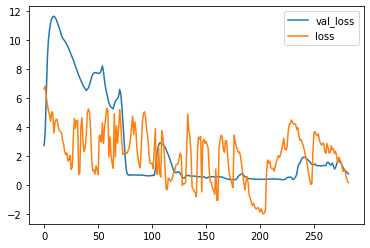

In [17]:
import gc
MC = ModelCheckpoint('./model.h5', verbose=True,monitor='val_loss',mode='min',
        save_weights_only=True,save_best_only=True)

stop = EarlyStopping(monitor = 'val_loss', restore_best_weights=True , patience = 5)

tr_it = iter(train_dataset)
batch_size = cfg['train_params']['train_batch']
#progress_bar = tqdm(range(0,cfg["train_params"]["max_num_steps"],batch_size))
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
two_hours = 60 * 60 * 2.3
losses = []
hist = []
for itr in progress_bar:#range(0,cfg["train_params"]["max_num_steps"],batch_size):
    inputs = np.zeros(shape=(batch_size,224,224,num_in_channels))
    targets = np.zeros(shape=(batch_size, num_targets))
    
    for i in range(batch_size):
        
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataset)
            data = next(tr_it)
            
        inputs[i] = data['image'].transpose(1,2,0)
        targets[i] = data['target_positions'].reshape(-1,num_targets)
   
    h = model.fit(inputs, targets,
                  batch_size = int(batch_size / 2) ,
                  validation_data = (val_inputs, val_targets),
                  verbose = 1,
                 callbacks = [MC, stop])
                  
    hist.append(h.history)
    gc.collect()
    # For training + submission, break if training exceeds 6 hours
    if (time.time()-t0) > two_hours:
        break
    if h.history['loss'][0] < 1.3 and h.history['val_loss'][0] < 1.3:
        break
    
    
vl = [hi['val_loss'] for hi in hist]
l = [hi['loss'] for hi in hist]
plt.plot(np.log(vl), label = 'val_loss')
plt.plot(np.log(l), label = 'loss')
plt.legend(loc=0)
plt.show()

In [18]:
model.save('modelv0.h5')


In [ ]:
from numpy import loadtxt
from keras.models import load_model
from keras.applications.resnet50 import ResNet50
from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.applications.resnet import ResNet101
# load model
model = load_model('modelv0.h5')
# summarize model.
model.summary()

/home/moriarty/.local/lib/python3.8/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


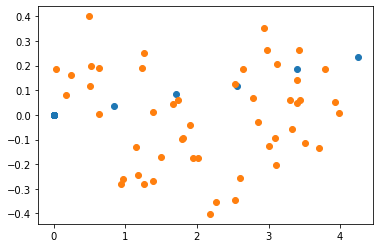

In [19]:
#Example Prediction:
import matplotlib.pyplot as plt
tr_it = iter(train_dataset)
a1 = next(tr_it)
inp = a1['image'].transpose(1,2,0)
act = a1['target_positions']
pred = model.predict(inp.reshape(-1,224,224,num_in_channels)).reshape(50,2)
plt.scatter(act[:,0], act[:,1])
plt.scatter(pred[:,0],pred[:,1])

Now we can use this model to predict from the test set.

In [20]:
test_cfg = cfg["test_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Test dataset/dataloader
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)

<ipython-input-20-540cf822d61a>:9: RuntimeWarning: you're running with a custom agents_mask
  test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)


In [21]:
t_shape = test_dataset[0]["target_positions"].shape
timestamps = []
agent_ids = []
coords = []
for it in tqdm(test_dataset):
    
    dat = it['image'].transpose(1,2,0)
    coords.append(np.array(model.predict(dat.reshape(1,224,224,num_in_channels)).reshape(t_shape)))
    timestamps.append(it["timestamp"])
    agent_ids.append(it["track_id"])
    
    

100%|██████████| 71122/71122 [3:41:38<00:00,  5.35it/s]  


In [22]:
from l5kit.evaluation import write_pred_csv


write_pred_csv('submission.csv',
                timestamps = np.array(timestamps),
                track_ids = np.array(agent_ids),
                coords = np.array(coords) )

I will play with some parameters later.  I am finally glad to just have something that functions.